In [1]:
# Quantum Artificial Life: simulating Lotka-Volterra equations #
################################################################
# This programs aims to implement a complete quantum simulation, executable (nowadays) in the Qasm Simulator

In [2]:
# We will use matlab scripts. This needs to have MATLAB API engine for python installed
import matlab.engine
eng = matlab.engine.start_matlab()

In [3]:
# QISKIT IMPORTS

from qiskit import BasicAer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit import Gate
from qiskit import IBMQ
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_state_city
from qiskit.providers.aer import StatevectorSimulator

In [2]:
# OTHER IMPORTS

import numpy as np
import sys
import json
import math
import matplotlib.pyplot as plt
import random

In [3]:
#############################################################
#-------------------- GLOBAL PARAMETERS --------------------#
#############################################################
# These parameters define behaviour of our simulation

# Death value for sigmaz:
deathvalue=-0.8

# grid dimensions. Modifying this requires doing the same at matlab script newgridf.m
L1=10; L2=10

# PROBABILITY OF SELF-REPLICATING
probprey=0.1
probpredator=0.2 # since our model requires this prob is proportional to number of preys,
# prob for the predator is actually p=probpredator*(# of alive preys)

# angle in radians, associated with amplitude damping at feeding interactions
f_ang=float(1.5856)
print(math.sin(f_ang/2)**2)
# angle in radians, associated with amplitude damping at time interactions
t_ang=0.4924
eta_t=math.sin(t_ang/2)**2
print(eta_t)
# angles that defines preys and predators. With these values, initially, sz=0.707 for preys and sz=-0.707 for predators
anglepred=math.pi/4
angleprey=3*math.pi/4

showplot=True # if we want computation to be faster, we can hide the plots of individuals moving around the grid

0.5074015662549861
0.05939959177729031


In [6]:
# AGENDA: this variable is essential to report every event that ocurred at our simulation
class agendapage:
    def __init__(self, individual1, individual2,step,typeofstep):
        self.a = individual1
        self.b = individual2
        self.step=step
        self.type=typeofstep # this can be 'feed', 'death' or 'newborn'
# each page consist of the id of 2 individuals, the step, and what happened

# to debug is useful to watch the agenda using the following function
def watchagenda(agenda):
    for k in range(len(agenda)):
        print(agenda[k].a,agenda[k].b,agenda[k].step,agenda[k].type)

In [7]:
# FEEDING, TIME AND SELF-REPLICATION MECHANISMS
def feed(circ,q,auxf):
    # only acting on the prey. sz value its decreased
    circ.barrier()
    circ.cry(f_ang,q,auxf)
    circ.cx(auxf,q)
    circ.reset(auxf)
    circ.barrier()

# in this model, time-passing is simulated using only one gate
def timep(circ,q):
    circ.i(q)

# in this model, self replication, is just
def selfreplicate(circ,pnew,ind_type):
    if ind_type=='predator':
        circ.u3(anglepred,0,0,pnew)
    elif ind_type=='prey':
        circ.u3(angleprey,0,0,pnew)
    else:
        raise ValueError('only \'prey\' and \'predator\' options are valid')

In [8]:
# our noise model

from qiskit.tools.monitor import job_monitor
import qiskit.providers.aer.noise as noise

backend=Aer.get_backend('qasm_simulator')
# implementing an amplitude damping error, only on the identity gate with parameter eta_t
noise_model = noise.NoiseModel()
error = noise.errors.amplitude_damping_error(eta_t)
noise_model.add_all_qubit_quantum_error(error, ['id'])
basis_gates = noise_model.basis_gates

In [9]:
# CRADLE FUNCTIONS: assign a random position to newborns individuals, making sure that new position is free.
# If we try #attempts times and we couldnt find a free place means that grid is too full so we should increase it size
attempts=10
# since number of individuals is limited, there will be always place so this wont be a problem

def cradleprey(k,preys,predators):
    for z in range(attempts): # We try to assign possition to new individual 5 times. If we're so unlucky that new individual find no place, self-replication will be aborted   
        newposx=random.randint(1,L1)
        newposy=random.randint(1,L2)
        free=True # boolean that indicates newposition is free
    
        for j in range(len(preys)):
            if preys[j][0]==newposx and preys[j][1]==newposy:
                free=False
        for j in range(len(predators)):
            if predators[j][0]==newposx and predators[j][1]==newposy:
                free=False
        if free: # search is done
            preys[k][0]=newposx
            preys[k][1]=newposy    
            break
    return free,preys 

def cradlepredator(k,preys,predators):
    for z in range(attempts): # We try to assign possition to new individual 5 times. If we're so unlucky that new individual find no place, self-replication will be aborted   
        newposx=random.randint(1,L1)
        newposy=random.randint(1,L2)
        free=True # boolean that indicates newposition is free
    
        for j in range(len(preys)):
            if preys[j][0]==newposx and preys[j][1]==newposy:
                free=False
        for j in range(len(predators)):
            if predators[j][0]==newposx and predators[j][1]==newposy:
                free=False
        if free: # search is done
            predators[k][0]=newposx
            predators[k][1]=newposy    
            break
    return free,predators

In [10]:
def checkdeath(fylename,q,Nprey,Npred,predators,preys):
    sz=eng.szcalc(fylename)[0] # using matlab, we transform the data into the sz values of each individual

    # 'isdead' vectors contain 1 if individual is dead and 0 if it is alive
    isdead1=np.zeros(Npred) 
    isdead2=np.zeros(Nprey)
    
    for k in range(Npred):
        if float(sz[k])<deathvalue: # this means l individual is dead
            isdead1[k]=1
    for k in range(Nprey):
        if float (sz[Npred+k])<deathvalue:
            isdead2[k]=1
    deadpred=np.sum(isdead1) # number of dead predators
    deadprey=np.sum(isdead2) # number of dead preys
    # if every individual is dead, we will save the last individual
    if deadpred==Npred:
        isdead1[Npred-1]=0
        predators=cradlepredator(Npred-1,preys,predators)[1] # this not-death individual needs a place to be
    if deadprey==Nprey:
        isdead2[Nprey-1]=0
        preys=cradleprey(Nprey-1,preys,predators)[1]
    
    return isdead1,isdead2,sz,predators,preys

In [11]:
# 'newstep' function does several things:
# - move individuals at grid (also, matlab function plots the grid)
# - if there are new interactions these are reported
# - with a certain probabilities there will be new-borns, and they will be reported

def newstep(preys,predators,agenda,step, isdead1,isdead2,currentpreys):
    # A numpy array object is not valid so for this step we need prey and predators matrices to be list objects
    if (type(preys)!=list):
        preys=preys.tolist()
    if (type(preys)!=list):
        predators=predators.tolist()
    news=eng.newgridf(preys,predators,sz,float(step),showplot,L1,L2,nargout=3)
    # new position for preys and predators. Also, we have an array reporting new interactions
    preys=news[1]
    predators=news[2]
    newint=news[0]
    newint=np.asarray(newint)
    newint=newint.astype(int)  # burocracy: we need numbers to be of the same class
    
    if newint[0][0]!=0: # if there is one or more interactions:
        for k in range(len(newint)): # to all of these interacions,
            newpage=agendapage(newint[k][0],newint[k][1],step+1,'feed') # we create a new page containing which individuals have interacted
            agenda.append(newpage) # and we append our page to the agenda
            
    # so far, we have reported interactions. Let us report new borns:
    # loop for predators
    p=probpredator*currentpreys # this is the actual probability of self-replicating
    
    for k in range(len(predators)): # for each predator
        if random.random()<p: # probability probpredator*num of alive preys of satisfying this condition
            for j in range(len(predators)): 
                if isdead1[k]==False and isdead1[j]==True: # in order to self-replicate we need an alive individual and a dead one individual
                    if cradlepredator(j,preys,predators)[0]==False: # this means there were no free place for new individual 
                        print('A self-replication was aborted since there were no to much place for new individual. Seems that grid is to much dense')
                    else:
                        newpage=agendapage(k+1,j+1,step+1,'newborn') # report of the new born
                        # page can be readed as: FATHER-SON-STEP-'NEWBORN'
                        agenda.append(newpage) # appending to the agenda
                        predators=cradlepredator(j,preys,predators)[1] # place new individual in some place (its cradle)
                        isdead1[j]=0
                    break

    # loop for preys
    for k in range(len(preys)):
        if random.random()<probprey: # probability probprey of satisfying this condition
            for j in range(len(preys)):
                if isdead2[k]==False and isdead2[j]==True: # in order to self-replicate we need an alive individual and a dead individual
                    if cradleprey(j,preys,predators)[0]==False: # this means there were no free place for new individual 
                        print('A self-replication was aborted since there were no to much place for new individual. Seems that grid is to much dense')
                    else:
                        newpage=agendapage(Npred+k+1,Npred+j+1,step+1,'newborn') # report of the new born
                        agenda.append(newpage) # appending to the agenda
                        preys=cradleprey(j,preys,predators)[1] # place new individual in some place (its cradle)
                        isdead2[j]=0
                    break
    return preys,predators,agenda

In [12]:
# creates a circuit which reproduces our system until a given step

def life(Nprey,Npred,step):

    N=Nprey+Npred
    q = QuantumRegister(N, 'q') # each individual is represented by 1 qubit. First, predators and then preys.
    auxfeed=QuantumRegister(1,'auxf') #ancillary qubit for feeding channel
    c = ClassicalRegister(N, 'c')
    circ=QuantumCircuit(q,auxfeed,c)
    anglepred=math.pi/4
    angleprey=3*math.pi/4
    
    for i in range(Npred):
        circ.u3(anglepred,0,0,q[i]) # initialition of state for predators...
        
    for i in range(Nprey):
        circ.u3(angleprey,0,0,q[i+Npred]) #... and preys
    
    circ.barrier()
    
    # now is time for interactions and timing
    for s in range(step): # for each step...
        for j in range(len(agenda)): # let us search which components of interaction matrix has an interaction in this step
            if agenda[j].step-1==s: # there is something at this step. It may be feeding, dying or newborn
                if agenda[j].type=='feed':
                    ind1=agenda[j].a-1 # number associated to first individual of this interaction (pred)
                    ind2=agenda[j].b-1 # number associated to second individual of this interaction (prey)
                    q2=q[int(ind2)] # phenotype of prey
                    feed(circ,q2,auxfeed[0])
                    circ.barrier()
                elif agenda[j].type=='newborn':
                    father=agenda[j].a-1
                    son=agenda[j].b-1
                    if father>Npred-1: # this means the father is a prey
                        selfreplicate(circ,q[int(son)],'prey') # thus, we are creating a new prey
                    else:
                        selfreplicate(circ,q[int(son)],'predator') # here father is a predator so we are creating a new predator
                    circ.barrier()
                elif agenda[j].type=='death':
                    circ.reset(q[int(agenda[j].a-1)]) # we reset dead qubits so that we can recycle them later
                    circ.barrier()
        

        # TIME PASSING FOR ALL INDIVIDUALS AT THE END OF ALL STEPS
        for j in range(N):
            timep(circ,q[j])
        circ.barrier()
        
    # measuring
    for k in range(N):
        circ.measure(q[k],c[k])
    return circ

In [13]:
############### EXECUTION OF SIMULATION ##############
# only previous step consist of choosing positions to initial individuals, and number of steps:

# maximum reached: 80 steps, 16 individuals (2-3 days long computations in a computer with 8GB RAM and i7 processor)
maxstep=80

### INITIAL POSITION OF INDIVIDUALS ########
# we have an initial number of individuals equal to the non-zero grid positions appearing here.
# For example. preys=[[3,6],[0,0],[0,0]] means that we have an initial individual in the (3,6) position but we can reach a maximum of 3 individuals
# coordinate (0,0) represents the cementery, where dead individuals are placed and not ploted
preys=[[2,3],[5,3],[8,9],[3,6],[0,0],[0,0],[0,0],[0,0],[0,0]]
predators=[[6,4],[7,1],[2,8],[0,0],[0,0],[0,0],[0,0]]
############################################

Nprey=len(preys); Npred=len(predators) # number of maximal individuals
Alivepreys=np.zeros(maxstep); Alivepredators=np.zeros(maxstep); # vectors containing alive individuals at each step (including 0 position)

#blanck page of agenda: creating system
page0=agendapage(0,0,0,'create system');
agenda=[page0]

# let us check which individuals are initially dead
isdead1=np.zeros(Npred)
isdead2=np.zeros(Nprey)

for k in range(Nprey):
    if preys[k][0]==0:
        isdead2[k]=1
        # reported as a death in first step
        starteddeath=agendapage(Npred+k+1,Npred+k+1,1,'death')
        agenda.append(starteddeath)
Alivepreys[0]=Nprey-np.sum(isdead2) # initial alive preys

for k in range(Npred):
    if predators[k][0]==0:
        isdead1[k]=1
        # reported as a death in first step
        starteddeath=agendapage(k+1,k+1,1,'death')
        agenda.append(starteddeath)
Alivepredators[0]=Npred-np.sum(isdead1) # initial alive predators

# at each step, we design, a circuit, measure it and save its data
for step in range(maxstep):
    
    # although this is not possible, if every individual is dead we should break simulation
    if isdead1.all() and isdead2.all():
        print('Simulation is over. Everyone died at step '+str(step)+'               \n')
        break
        
    # design the circuit for given conditions
    circ=life(Nprey,Npred,step)
    
    #execute the circuit, using our noise model
    data=execute(circ, backend,basis_gates=basis_gates,noise_model=noise_model).result().get_counts(circ)
    # data is saved into a .txt file
    fylename='lastversion'+str(step)+'.txt'
    f = open (fylename,'w')
    result = json.dumps(data)
    f.write(result)
    f.close()
    
    # with the data, we can check which individuals are dead
    [newdeaths1,newdeaths2,sz,predators,preys]=checkdeath(fylename,step,Nprey,Npred,predators,preys)
    
    # report death of the individuals that were not dead and now are
    for k in range(Npred):
        if newdeaths1[k]==1 and isdead1[k]==0:
            newpage=agendapage(k+1,k+1,step+1,'death') # register the new death at the agenda
            agenda.append(newpage)
    for k in range(Nprey):
        if newdeaths2[k]==1 and isdead2[k]==0:
            newpage=agendapage(k+1,k+1,step+1,'death')
            agenda.append(newpage)
    isdead1=newdeaths1
    isdead2=newdeaths2
    
    # updating number of alive individuals
    if step>0:
        Alivepredators[step]=Npred-np.sum(isdead1)
        Alivepreys[step]=Nprey-np.sum(isdead2)
        

    
    
    # moving death individuals to the cementery
    for k in range(Npred):
        if isdead1[k] and sz[k]<deathvalue:
            predators[k][0]=0
            predators[k][1]=0 # cemetery
    for k in range (Nprey):
        if isdead2[k] and sz[Npred+k]<deathvalue:
            preys[k][0]=0
            preys[k][1]=0
    newthings=newstep(preys,predators,agenda,step,isdead1,isdead2,Alivepreys[step])
    preys=newthings[0]
    predators=newthings[1]
    agenda=newthings[2]
    
    # step is over, let us show how much progress of simulation is done
    sys.stdout.write(f"Simulation progress: step {step+1} out of {maxstep} completed: {100*(step+1)/(maxstep)}%                     \r" )
    sys.stdout.flush()

    # you may want to see final circuit
    # circ.draw(output='mpl')

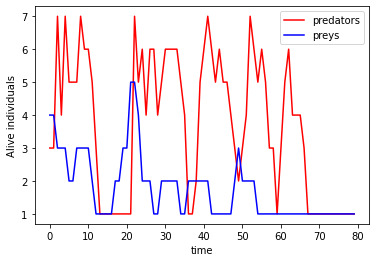

In [14]:
# time plot of alive preys(blue) and alive predators ()
plt.plot(Alivepredators,'r-',label='predators');
plt.plot(Alivepreys,'b-',label='preys');
plt.legend();
plt.xlabel('time');
plt.ylabel('Alive individuals');

In [22]:
# useful for debugging and other purpouses
watchagenda(agenda)

0 0 0 create system
12 12 1 death
13 13 1 death
14 14 1 death
15 15 1 death
16 16 1 death
4 4 1 death
5 5 1 death
6 6 1 death
7 7 1 death
1 9 1 feed
4 4 2 death
5 5 2 death
6 6 2 death
7 7 2 death
5 5 2 death
6 6 2 death
7 7 2 death
8 8 2 death
9 9 2 death
1 9 2 feed
3 11 2 feed
1 4 2 newborn
2 5 2 newborn
4 6 2 newborn
5 7 2 newborn
8 12 2 newborn
1 1 3 death
2 2 3 death
1 12 3 feed
2 5 3 feed
4 7 3 feed
1 1 4 death
2 2 4 death
5 5 4 death
7 7 4 death
4 1 4 newborn
6 2 4 newborn
2 6 5 feed
11 12 5 feed
1 5 5 newborn
3 7 5 newborn
10 8 5 newborn
6 6 6 death
11 12 6 feed
1 6 6 newborn
5 5 7 death
1 4 7 feed
2 8 7 feed
1 1 8 death
3 3 8 death
4 4 8 death
5 5 8 death
2 8 8 feed
8 10 8 feed
2 1 8 newborn
6 3 8 newborn
7 4 8 newborn
1 11 9 feed
6 10 9 feed
1 5 9 newborn
6 6 10 death
3 4 10 feed
2 6 10 newborn
3 3 11 death
4 4 11 death
3 3 11 death
5 11 11 feed
2 3 11 newborn
5 4 11 newborn
2 2 12 death
7 7 12 death
4 4 12 death
1 3 12 feed
1 8 12 feed
3 8 12 feed
1 2 12 newborn
5 7 12 newbo

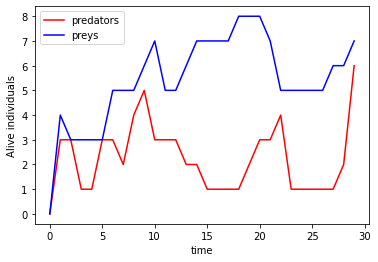

In [30]:
# time plot of alive preys(blue) and alive predators ()
plt.plot(Alivepredators2,'r-',label='predators');
plt.plot(Alivepreys2,'b-',label='preys');
plt.legend();
plt.xlabel('time');
plt.ylabel('Alive individuals');

In [27]:
# If necessary, we can save the data as .txt file
np.savetxt('preys1', Alivepreys)
np.savetxt('preys2', Alivepreys)
np.savetxt('predators1', Alivepredators)
np.savetxt('predators2', Alivepredators)